# Comparing ARCH and scipy minimize

In [1]:
import numpy as np
import pandas as pd
import arch
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.optimize import minimize
from arch import arch_model

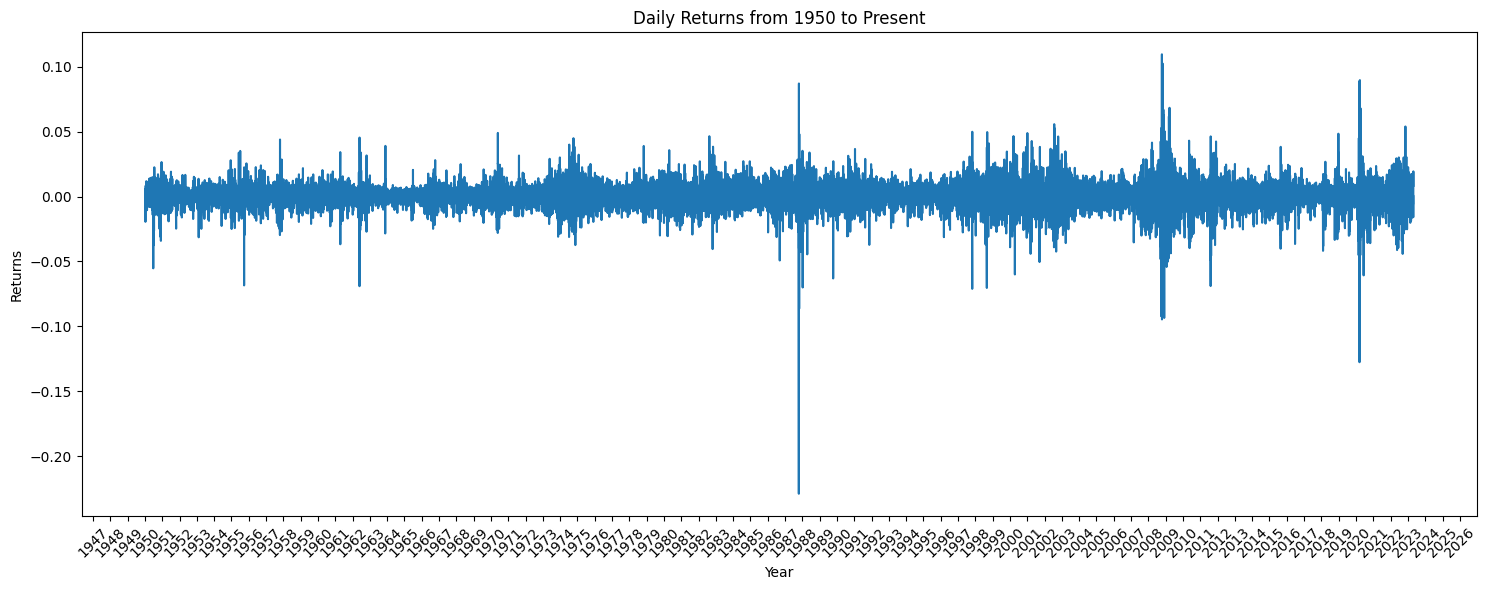

18449


In [12]:
data = pd.read_csv('SP.csv', sep=';')

data['Date'] = pd.to_datetime(data['Date'])
# data = data.iloc[500:1000]
plt.figure(figsize=(15, 6))
plt.plot(data['Date'], data['Return'])
plt.xlabel('Year')
plt.ylabel('Returns')
plt.title('Daily Returns from 1950 to Present')
# Setting x-axis to show only the years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
y = data['Return']
print(len(y))


# The Minimizing model
Using the likelihood function:
$$f(x_t|x_{t-1})=\frac{1}{\sqrt{2\pi\sigma_t^2(\theta)}}exp{-\frac{(x_t -\mu - \phi x_{t-1})^2}{2\sigma_t^2(\theta)}}$$

with $\sigma^2_t(\theta) = \omega + \alpha x_{t-1}^2 + \beta \sigma_{t-1}^2$
The likelihood contribution is 
$$log L_t = -0.5*\left[log 2\pi + log \sigma_t^2(\theta) +\frac{(x_t -\mu - \phi x_{t-1})^2}{2\sigma_t^2(\theta)}\right]$$

In [3]:

                                                         
def garch_likelihood(params, data):
    mu, phi, omega, alpha, beta = params
    n = len(data)
    x = np.zeros_like(data)
    sigma2 = np.zeros_like(data)

    for t in range(1, n):
        x[t] = data[t] - (mu + phi * data[t-1])
        sigma2[t] = omega + alpha * x[t-1]**2 + beta * sigma2[t-1]

    likelihood = 0.5 * np.sum((np.log(2 * np.pi) + np.log(sigma2[1:]) + x[1:]**2 / sigma2[1:]))
    return  likelihood


def optimize_garch(data):
    # Convert data to numpy array if it's a pandas series
    if isinstance(data, pd.Series):
        data = data.to_numpy()

    # Initial parameter guesses
    initial_params = [0, 0.5, 0.1, 0.1, 0.8]

    # Bounds for omega, alpha, beta
    bounds = [(None, None), (None, None), (1e-6, None), (1e-6, None), (1e-6, None)]

    # Minimize the negative likelihood
    result = minimize(lambda params: garch_likelihood(params, data), 
                  initial_params, method='L-BFGS-B', bounds=bounds)

    return result
# Example usage with some data
data = y  # Replace with your actual data
result = optimize_garch(data)
print(result)

/tmp/ipykernel_228394/3966445121.py:9: RuntimeWarning: overflow encountered in scalar multiply
  sigma2[t] = omega + alpha * x[t-1]**2 + beta * sigma2[t-1]
/home/august/.venvs/jupyter/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -55602.65152322303
        x: [-5.397e-03  4.836e-01  6.100e-05  9.022e-02  2.406e-01]
      nit: 7
      jac: [-1.196e+06  5.480e+03 -4.593e+07 -9.903e+03 -5.911e+03]
     nfev: 144
     njev: 24
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


In [4]:
# Printing the optimized parameters
if result.success:
    optimized_params = result.x
    print("Optimized Parameters:")
    print(f"mu: {optimized_params[0]}")
    print(f"phi: {optimized_params[1]}")
    print(f"omega: {optimized_params[2]}")
    print(f"alpha: {optimized_params[3]}")
    print(f"beta: {optimized_params[4]}")
else:
    print("Optimization was not successful. Details:")
    print(result)

Optimized Parameters:
mu: -0.00539744740280625
phi: 0.483610154907273
omega: 6.099947460385085e-05
alpha: 0.09021946935922354
beta: 0.24056426382393517


In [5]:
# Assuming your_series_data is your time series data
model = arch_model(y, mean='AR', lags=1, vol='Garch', p=1, q=1)
model_fit = model.fit(update_freq=10)

print(model_fit.summary())

Inequality constraints incompatible    (Exit mode 4)
            Current function value: -62517.76044143112
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
                           AR - GARCH Model Results                           
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                62517.8
Distribution:                  Normal   AIC:                          -125026.
Method:            Maximum Likelihood   BIC:                          -124986.
                                        No. Observations:                18448
Date:                Thu, Jan 25 2024   Df Residuals:                    18446
Time:                        12:48:00   Df Model:                            2
                                  Mean Model                                  
    

/home/august/.venvs/jupyter/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.974e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/august/.venvs/jupyter/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/august/.venvs/jupyter/lib/python3.11/site-packages/arch/univariate/base.py:1894: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). T

# ARCH Results
Mu = 0.00025359 \
Phi = 0.1664 \
Omega = 0.0000091651 \
Alpha = 0.1023 \
Beta = 0.5984 

# Third Model Optimized Parameters:
mu: 0.00013612797582089422\
phi: 0.49815479017415876\
omega: 7.231128574642902e-06\
alpha: 0.08852543683022811\
beta: 0.6910927793581825

# First Model Optimized Parameters:
mu: 0.00013583438623674423 \
phi: 0.4981530397720939 \
omega: 0.00000723068  \
alpha: 0.08852368544617216 \
beta: 0.6910730827361448


# Second Model Optimized Parameters:
mu: 0.00000868124\
phi: 0.4919351382904341\
omega: 0.00002343315 \
alpha: 0.044970918141943934\
beta: 0.22812610647851816


In [8]:
import numpy as np
from scipy.optimize import minimize

def neg_log_likelihood(sigma, data):
    n = len(data)
    # Assuming a normal distribution for the data
    likelihood = n * np.log(sigma) + np.sum((data - np.mean(data))**2) / (2 * sigma**2)
    return likelihood

def estimate_sigma(data):
    # Initial guess for sigma
    initial_sigma = np.std(data, ddof=1)  # ddof=1 for sample standard deviation

    # Minimize the negative log-likelihood
    result = minimize(lambda sigma: neg_log_likelihood(sigma, data),
                      x0=initial_sigma, method='L-BFGS-B', bounds=[(1e-8, None)])

    if result.success:
        estimated_sigma = result.x[0]
    else:
        raise ValueError("Optimization did not converge")

    # Compare with direct standard deviation
    direct_sigma = np.std(data, ddof=1)

    return estimated_sigma, direct_sigma

# Example usage
data = np.random.normal(0, 1, 1000)  # Example data
estimated_sigma, direct_sigma = estimate_sigma(data)
print("Estimated Sigma:", estimated_sigma)
print("Direct Sigma:", direct_sigma)


Estimated Sigma: 0.9800933364465745
Direct Sigma: 0.9805837562368311


In [13]:
import numpy as np
import matplotlib.pyplot as plt

def estimate_sigma(data):
    # Estimate sigma using MLE
    result = minimize(lambda sigma: neg_log_likelihood(sigma, data),
                      x0=np.std(data, ddof=1), method='L-BFGS-B', bounds=[(1e-8, None)])
    if result.success:
        return result.x[0]
    else:
        raise ValueError("Optimization did not converge")

def neg_log_likelihood(sigma, data):
    n = len(data)
    likelihood = n * np.log(sigma) + np.sum((data - np.mean(data))**2) / (2 * sigma**2)
    return likelihood

# Your original data series
data_series = y# Replace this with your actual data series

# Sampling and computing differences
log_differences = []
for _ in range(1000):
    sample_size = np.random.randint(100, 3001)  # Sample size between 100 and 3000
    sample = np.random.choice(data_series, sample_size, replace=False)
    estimated_sigma = estimate_sigma(sample)
    direct_sigma = np.std(sample, ddof=1)
    log_diff = estimated_sigma - direct_sigma # np.log(np.abs(estimated_sigma - direct_sigma))
    log_differences.append(log_diff)

# Creating a histogram of the log differences
plt.hist(log_differences, bins=30, edgecolor='black')
plt.xlabel('Logarithmic Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Logarithmic Differences in Estimated Sigma')
plt.show()


ValueError: Optimization did not converge